## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [1]:
"""
Author: Víctor Marcuello Baquero (741278),
        Félix Ozcoz Eraso (801108)
Date: 14/04/2024
File: Practica3_Notebook_741278_801108.ipynb
Comm: Fichero que contiene el código implementado para realizar cada
      una de las partes de la práctica 3
"""
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install medmnist
import medmnist
from medmnist import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [2]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
im_size = 64
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])
TRAIN_IMAGES = 1000
data_labels = info['label']

# Diccionario que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "num_channels": n_channels,
              "num_classes": num_classes,"num_images":TRAIN_IMAGES, "data_labels": data_labels}

# Partial display of information in info
print("Medmnist class: "      , info['python_class'])   #  Medmnist dataset type:   BloodMNIST, ChestMNIST, DermaMNIST, ....
print("Url: "                 , info['url'])            #  Url dir
print("Classification task: " , info['task'])           #  Classification tasks:
print("Class labels: "        , info['label'])          #  Class labels
print("Samples: "             , info['n_samples'])      #  Samples subdatasets


# Preprocesado de datos mediante la definición de la transformación de datos
def preprocessing_data(parameters):
  data_transform = transforms.Compose([
    transforms.Resize((parameters["im_size"],parameters["im_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
  ])

  full_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True)
  full_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True)
  full_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True)

  idx_train = np.random.choice(len(full_train_dataset),size=parameters["num_images"],replace=False)
  train_dataset = [full_train_dataset[i] for i in idx_train]

  idx_valid = np.random.choice(len(full_valid_dataset),size=300,replace=False)
  valid_dataset = [full_valid_dataset[i] for i in idx_valid]

  idx_test = np.random.choice(len(full_test_dataset),size=600,replace=False)
  test_dataset = [full_test_dataset[i] for i in idx_test]

  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"], shuffle=True)

  return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset

train_loader,valid_loader,test_loader,train_dataset,valid_dataset,test_dataset = preprocessing_data(parameters)

Medmnist class:  BloodMNIST
Url:  https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1
Classification task:  multi-class
Class labels:  {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Samples:  {'train': 11959, 'val': 1712, 'test': 3421}


100%|██████████| 35461855/35461855 [00:04<00:00, 8762961.35it/s] 


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


<ipython-input-3-09255383280d>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=(2,2))


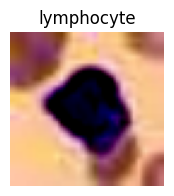

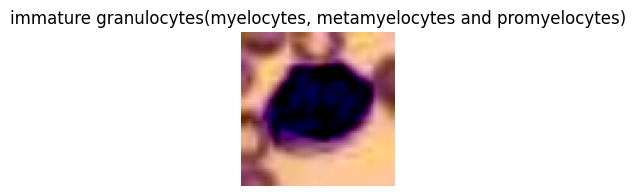

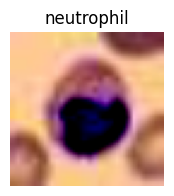

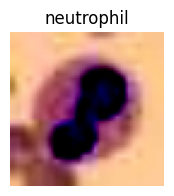

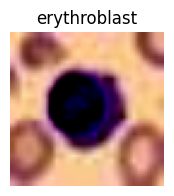

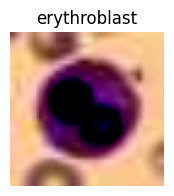

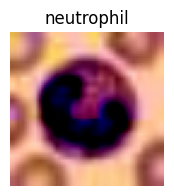

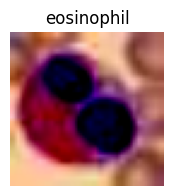

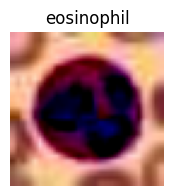

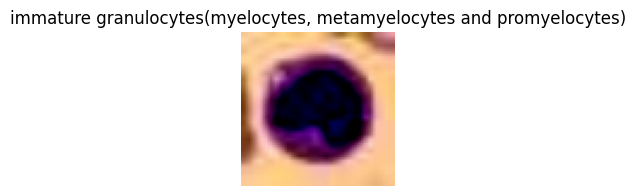

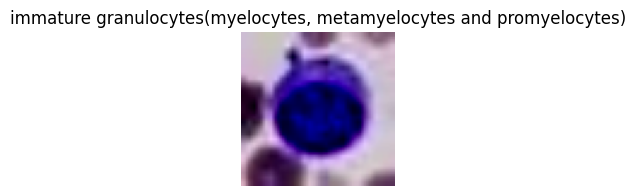

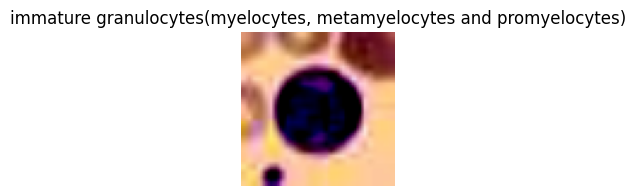

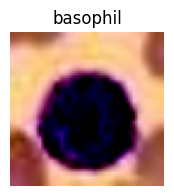

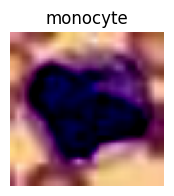

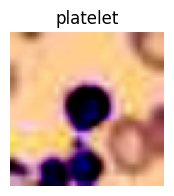

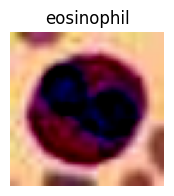

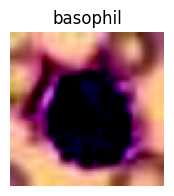

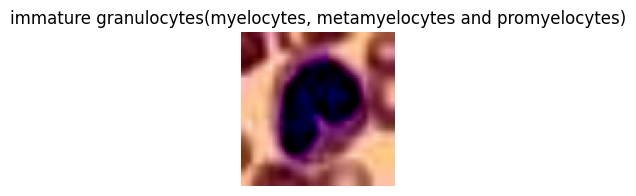

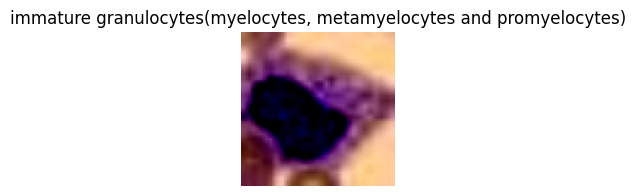

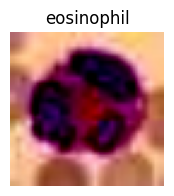

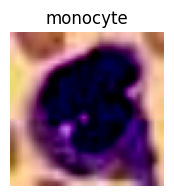

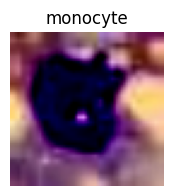

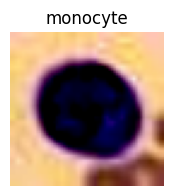

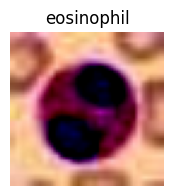

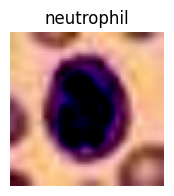

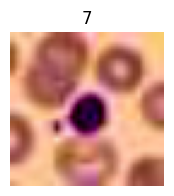

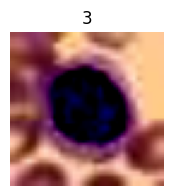

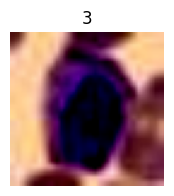

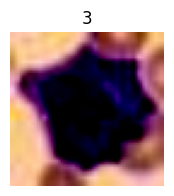

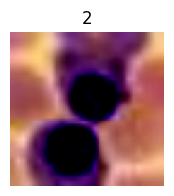

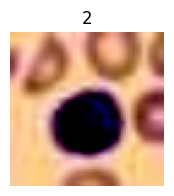

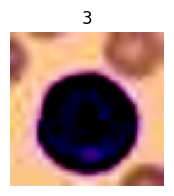

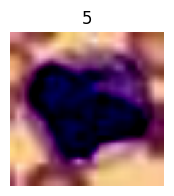

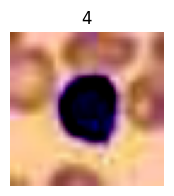

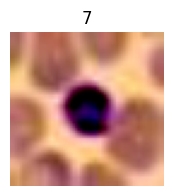

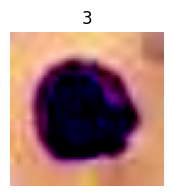

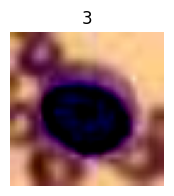

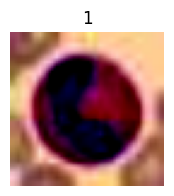

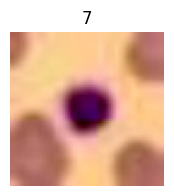

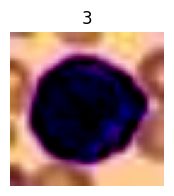

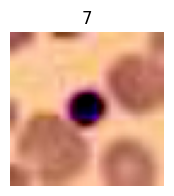

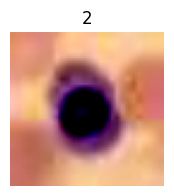

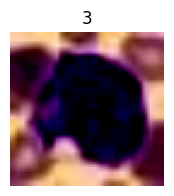

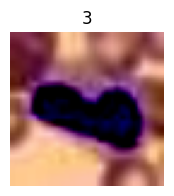

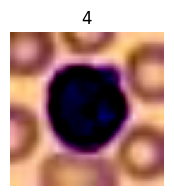

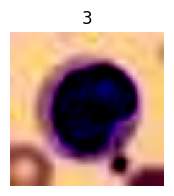

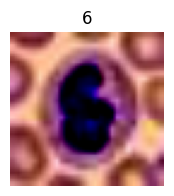

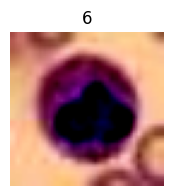

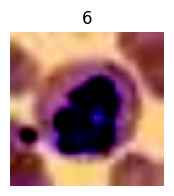

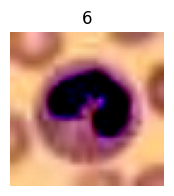

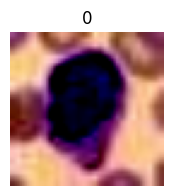

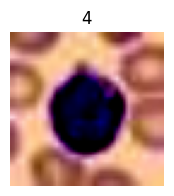

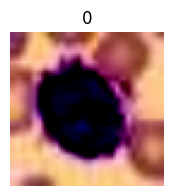

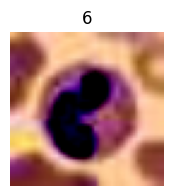

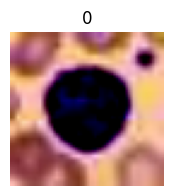

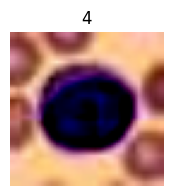

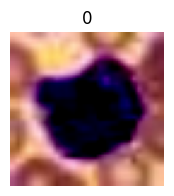

In [3]:
## Your code

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):
  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','').replace(']','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label])
    plt.axis("off")
  plt.show()

# Visualizador de imágenes alojadas en batches (fragmentos de un dataset) a través de un pipeline DataLoader
def dataloader_visualizer(data_loader,num_batches):
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()

# Visualizador de la red asociada al modelo de aprendizaje
def net_model_visualizer(net_model):
  print(net_model)
  print('Total Parameters:',
       sum([torch.numel(p) for p in net_model.parameters()])
  )
  print('Trainable Parameters:',
       sum([torch.numel(p) for p in net_model.parameters() if p.requires_grad])
  )

dataset_visualizer(train_dataset,5)

dataloader_visualizer(train_loader,1)
#dataloader_visualizer(valid_loader,1)
#dataloader_visualizer(test_loader,1)

In [5]:
# Define a simple CNN model

# Simula una capa que contiene <in_channels> filtros convolucionales de entrada
# y <out_channels> filtros convolucionales de salida
def convolution(in_channels,out_channels):
  layer = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
  )

  return layer

# Simula una capa de doble convolución
def double_convolution(in_channels,out_channels):
  conv_op = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU(),
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU()
  )

  return conv_op

class Net(nn.Module):
    def __init__(self, parameters):
        super(Net, self).__init__()

        self.layer1 = convolution(parameters["num_channels"],8)
        self.layer2 = convolution(8,16)
        self.layer3 = convolution(16,32)
        self.layer4 = convolution(32,64)

        self.fc1 = nn.Linear(64,32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32,parameters["num_classes"])

        #End your code

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x,1).reshape(x.size(0),-1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)

        return x

"""
class UNet(nn.Module):
  def __init__(self,parameters):
    super(UNet,self).__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(parameters["num_channels"],64,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64,64,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.decoder = nn.Sequential(
      nn.Conv2d(64,128,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128,128,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.ConvTranspose2d(128,64,kernel_size=2,stride=2),
      nn.Conv2d(64,parameters["num_classes"],kernel_size=1)
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
"""


"""
class UNetCNN(nn.Module):
  def __init__(self,parameters):
    super(UNetCNN,self).__init__()

    self.max_pool2d = nn.MaxPool2d(2,2)

    self.down_conv1 = double_convultion(parameters["n_channels"],8)
    self.down_conv2 = double_convultion(8,16)
    self.down_conv3 = double_convultion(16,32)
    self.down_conv4 = double_convultion(32,64)
    self.down_conv5 = double_convultion(64,128)

    self.up_trans1 = nn.ConvTranspose2d(128,64,2,2)
    self.up_conv1 = double_convultion(128,64)
    self.up_trans2 = nn.ConvTranspose2d(64,32,2,2)
    self.up_conv2 = double_convultion(64,32)
    self.up_trans3 = nn.ConvTranspose2d(32,16,2,2)
    self.up_conv3 = double_convultion(32,16)
    self.up_trans4 = nn.ConvTranspose2d(16,8,2,2)
    self.up_conv4 = double_convultion(16,8)

    self.final_layer = nn.Conv2d(8,parameters["num_classes"],1)

  def forward(self,x):
    print(x.shape)
    down1 = self.down_conv1(x)
    print(down1.shape)
    down2 = self.max_pool2d(down1)
    print(down2.shape)
    down3 = self.down_conv2(down2)
    print(down3.shape)
    down4 = self.max_pool2d(down3)
    print(down4.shape)
    down5 = self.down_conv3(down4)
    print(down5.shape)
    down6 = self.max_pool2d(down5)
    print(down6.shape)
    down7 = self.down_conv4(down6)
    print(down7.shape)
    down8 = self.max_pool2d(down7)
    print(down8.shape)
    down9 = self.down_conv5(down8)
    print(down9.shape)

    up1 = self.up_trans1(down9)
    print(up1.shape)
    x = self.up_conv1(torch.cat([down7,up1],1))

    up2 = self.up_trans2(x)
    print(up2.shape)
    x = self.up_conv2(torch.cat([down5,up2],1))

    up3 = self.up_trans3(x)
    print(up3.shape)
    x = self.up_conv3(torch.cat([down3,up3],1))

    up4 = self.up_trans4(x)
    print(up4.shape)
    x = self.up_conv4(torch.cat([down1,up4],1))

    final_layer = self.final_layer(x)

    print(final_layer.shape)
    return final_layer
"""

"""
class ResNet18(nn.Module):
  def __init__(self,parameters):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)
    self.bn1 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(3,2,1)

    self.conv2_block1 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv2_block2 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv3_block1 = nn.Sequential(
        nn.Conv2d(64,128,3,2,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv3_block2 = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv4_block1 = nn.Sequential(
        nn.Conv2d(128,256,3,2,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv4_block2 = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv5_block1 = nn.Sequential(
        nn.Conv2d(256,512,3,2,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.conv5_block2 = nn.Sequential(
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(512,parameters["num_classes"])

  def forward(self,x):
    print(x.shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool(x)

    print(x.shape)
    x = self.conv2_block1(x)
    x = self.conv2_block2(x)
    x = self.conv3_block1(x)
    x = self.conv3_block2(x)
    x = self.conv4_block1(x)
    x = self.conv4_block2(x)
    x = self.conv5_block1(x)
    x = self.conv5_block2(x)

    x = self.avgpool(x)
    x = self.fc(x)

    return x
"""

'\nclass ResNet18(nn.Module):\n  def __init__(self,parameters):\n    super(ResNet18, self).__init__()\n\n    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)\n    self.bn1 = nn.BatchNorm2d(64)\n    self.maxpool = nn.MaxPool2d(3,2,1)\n\n    self.conv2_block1 = nn.Sequential(\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64),\n        nn.ReLU(True),\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64)\n    )\n\n    self.conv2_block2 = nn.Sequential(\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64),\n        nn.ReLU(True),\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64)\n    )\n\n    self.conv3_block1 = nn.Sequential(\n        nn.Conv2d(64,128,3,2,1),\n        nn.BatchNorm2d(128),\n        nn.ReLU(True),\n        nn.Conv2d(128,128,3,1,1),\n        nn.BatchNorm2d(128)\n    )\n\n    self.conv3_block2 = nn.Sequential(\n        nn.Conv2d(128,128,3,1,1),\n        nn.BatchNorm2d(128),\n        nn.ReLU(True),\n        nn.Conv2d(128,128,3,1,1),

100%|██████████| 10/10 [00:00<00:00, 47.78it/s]



Accuracy: 0.30666666666666664
AUC: 0.7833954018768546
F1 Score: 4.20994979461433
Confusion Matrix:
tensor([[ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 58.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  1.,  0.,  0.,  1.],
        [ 0.,  0.,  0., 46.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 18.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 31.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 45.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  2.,  0.,  0., 46.]])


100%|██████████| 10/10 [00:00<00:00, 47.43it/s]



Accuracy: 0.5366666666666666
AUC: 0.8804759021536105
F1 Score: 4.524219103666817
Confusion Matrix:
tensor([[ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.],
        [ 0., 42.,  1., 14.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  4., 16.,  0.,  0.,  1., 11.],
        [ 0.,  1.,  0., 45.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  4., 14.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 31.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 10., 13.,  0.,  0., 21.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 49.51it/s]



Accuracy: 0.6333333333333333
AUC: 0.9105455136426057
F1 Score: 4.77439293598234
Confusion Matrix:
tensor([[ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.],
        [ 0., 51.,  0.,  6.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  7., 13.,  0.,  0.,  2., 10.],
        [ 0.,  1.,  0., 42.,  0.,  0.,  3.,  0.],
        [ 0.,  0.,  5., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  4.,  0.,  0., 40.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 34.74it/s]



Accuracy: 0.6366666666666667
AUC: 0.9359100616033564
F1 Score: 4.785651793525809
Confusion Matrix:
tensor([[ 0.,  0.,  0., 21.,  0.,  0.,  0.,  0.],
        [ 0., 53.,  0.,  4.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  3., 14.,  0.,  0.,  2., 13.],
        [ 0.,  1.,  0., 41.,  0.,  0.,  4.,  0.],
        [ 0.,  0.,  3., 14.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 28.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  4.,  0.,  0., 41.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 49.38it/s]



Accuracy: 0.66
AUC: 0.9447033324795487
F1 Score: 4.824094281972938
Confusion Matrix:
tensor([[ 0.,  0.,  0., 20.,  0.,  0.,  1.,  0.],
        [ 0., 55.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  6., 12.,  1.,  0.,  3., 10.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  5.,  0.],
        [ 0.,  0.,  3., 13.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  4.,  1.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  0., 43.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 49.09it/s]



Accuracy: 0.6666666666666666
AUC: 0.9522932788295415
F1 Score: 4.856653829696191
Confusion Matrix:
tensor([[ 0.,  0.,  0., 19.,  1.,  0.,  1.,  0.],
        [ 0., 55.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  3., 11.,  1.,  0.,  4., 13.],
        [ 0.,  1.,  0., 38.,  0.,  1.,  6.,  0.],
        [ 0.,  0.,  2.,  9.,  3.,  0.,  4.,  0.],
        [ 0.,  0.,  0., 21.,  0.,  9.,  1.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  0., 43.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 46.67it/s]



Accuracy: 0.6833333333333333
AUC: 0.9558447338954683
F1 Score: 4.872789995687796
Confusion Matrix:
tensor([[ 0.,  0.,  0., 19.,  1.,  0.,  1.,  0.],
        [ 0., 55.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 10.,  9.,  0.,  0.,  3., 10.],
        [ 0.,  1.,  0., 38.,  0.,  0.,  7.,  0.],
        [ 0.,  0.,  2.,  8.,  2.,  0.,  6.,  0.],
        [ 0.,  0.,  0., 23.,  0.,  7.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 48.77it/s]



Accuracy: 0.68
AUC: 0.9598304260539152
F1 Score: 4.8719486081370444
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 53.,  0.,  4.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 11.,  7.,  0.,  0.,  4., 10.],
        [ 0.,  1.,  0., 36.,  0.,  0.,  9.,  0.],
        [ 0.,  0.,  1.,  7.,  4.,  0.,  6.,  0.],
        [ 0.,  0.,  0., 23.,  0.,  7.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 49.72it/s]



Accuracy: 0.7033333333333334
AUC: 0.9613857469722278
F1 Score: 4.905692438402719
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 55.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 10.,  7.,  0.,  0.,  4., 11.],
        [ 0.,  1.,  0., 34.,  0.,  2.,  9.,  0.],
        [ 0.,  0.,  1.,  5.,  6.,  0.,  6.,  0.],
        [ 0.,  0.,  0., 17.,  0., 13.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 15.24it/s]



Accuracy: 0.6966666666666667
AUC: 0.9615294988575682
F1 Score: 4.872506504770164
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 53.,  0.,  4.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 10., 11.,  2.,  0.,  2.,  7.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  5.,  0.],
        [ 0.,  0.,  1.,  9.,  4.,  0.,  4.,  0.],
        [ 0.,  0.,  0., 21.,  0.,  9.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 41.94it/s]



Accuracy: 0.7333333333333333
AUC: 0.9659926561594409
F1 Score: 4.891973969631236
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 52.,  0.,  5.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 19.,  6.,  0.,  0.,  3.,  4.],
        [ 0.,  0.,  1., 35.,  0.,  2.,  8.,  0.],
        [ 0.,  0.,  2.,  4., 10.,  0.,  2.,  0.],
        [ 0.,  0.,  0., 19.,  0., 11.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 48.35it/s]



Accuracy: 0.74
AUC: 0.9671933034841202
F1 Score: 4.88548951048951
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 18.,  7.,  1.,  0.,  1.,  5.],
        [ 0.,  1.,  1., 36.,  0.,  1.,  7.,  0.],
        [ 0.,  0.,  2.,  6., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 19.,  0., 11.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 47.18it/s]



Accuracy: 0.7366666666666667
AUC: 0.9680953482893409
F1 Score: 4.87341217696014
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 51.,  0.,  6.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 19.,  7.,  2.,  0.,  1.,  3.],
        [ 0.,  0.,  1., 38.,  0.,  0.,  7.,  0.],
        [ 0.,  0.,  2.,  5., 11.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 21.,  0.,  9.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 50.64it/s]



Accuracy: 0.7633333333333333
AUC: 0.9707634589290518
F1 Score: 4.882430647291942
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 22.,  6.,  0.,  0.,  1.,  3.],
        [ 0.,  1.,  1., 37.,  0.,  0.,  7.,  0.],
        [ 0.,  0.,  2.,  3., 13.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 21.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 51.05it/s]



Accuracy: 0.7633333333333333
AUC: 0.9709028105850264
F1 Score: 4.900087642418931
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 22.,  6.,  0.,  0.,  1.,  3.],
        [ 0.,  1.,  1., 35.,  0.,  2.,  7.,  0.],
        [ 0.,  0.,  2.,  3., 13.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 18.,  0., 12.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 51.94it/s]



Accuracy: 0.78
AUC: 0.9727504211905182
F1 Score: 4.890453145622526
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 20.,  6.,  2.,  0.,  1.,  3.],
        [ 0.,  1.,  1., 40.,  0.,  1.,  3.,  0.],
        [ 0.,  0.,  0.,  3., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 19.,  0., 12.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 33.86it/s]



Accuracy: 0.76
AUC: 0.9731077309128042
F1 Score: 4.884413309982486
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 53.,  0.,  4.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 19.,  7.,  2.,  0.,  1.,  3.],
        [ 0.,  0.,  1., 38.,  0.,  0.,  7.,  0.],
        [ 0.,  0.,  0.,  3., 15.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 21.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 46.88it/s]



Accuracy: 0.7966666666666666
AUC: 0.9742133522755239
F1 Score: 4.942156003505697
Confusion Matrix:
tensor([[ 4.,  0.,  0., 14.,  2.,  0.,  1.,  0.],
        [ 0., 52.,  0.,  4.,  0.,  0.,  1.,  1.],
        [ 0.,  0., 25.,  4.,  1.,  0.,  1.,  1.],
        [ 0.,  0.,  1., 35.,  0.,  2.,  8.,  0.],
        [ 0.,  0.,  1.,  0., 16.,  0.,  1.,  0.],
        [ 0.,  0.,  0., 17.,  1., 13.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 48.48it/s]



Accuracy: 0.79
AUC: 0.9758922290266434
F1 Score: 4.9052446011458795
Confusion Matrix:
tensor([[ 0.,  0.,  0., 18.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 22.,  6.,  2.,  0.,  1.,  1.],
        [ 0.,  1.,  2., 38.,  0.,  2.,  3.,  0.],
        [ 0.,  0.,  0.,  2., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 17.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


100%|██████████| 10/10 [00:00<00:00, 49.05it/s]



Accuracy: 0.8166666666666667
AUC: 0.9775165775209262
F1 Score: 4.957746478873239
Confusion Matrix:
tensor([[ 4.,  0.,  0., 14.,  2.,  0.,  1.,  0.],
        [ 0., 54.,  0.,  3.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 23.,  6.,  1.,  0.,  1.,  1.],
        [ 0.,  0.,  2., 36.,  0.,  6.,  2.,  0.],
        [ 0.,  0.,  0.,  2., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 12.,  0., 19.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]])


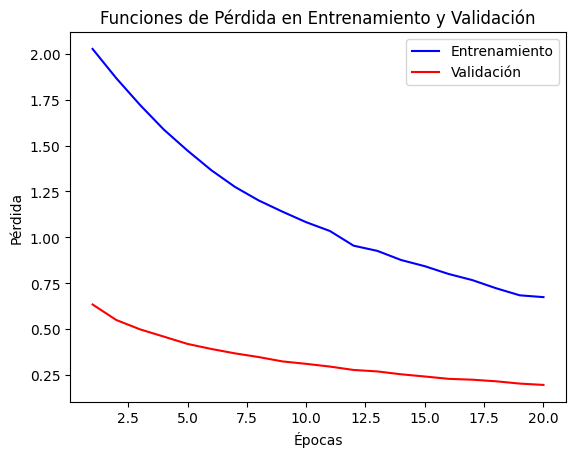

In [6]:
# Train and validate the model
def train_epoch(model,train_loader,optimizer,criterion,epoch,parameters):
    train_loss_epoch = 0

    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(train_loader),total=len(train_loader)):
        outputs = model(X_batch)

        if parameters["info_task"] == 'binary-class':
          y_batch = y_batch.to(torch.float32)
        else:
          y_batch = y_batch.squeeze().long()

        loss = criterion(outputs,y_batch)

        train_loss_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_epoch /= parameters["batch_size"]

    return train_loss_epoch

def validate_epoch(model,valid_loader,criterion,epoch,parameters):
    valid_loss_epoch = 0

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
          outputs = model(X_batch)

          if parameters["info_task"] == 'binary-class':
            y_batch = y_batch.to(torch.float32)
          else:
            y_batch = y_batch.squeeze().long()

          loss = criterion(outputs,y_batch)

          valid_loss_epoch += loss.item()

          outputs = outputs.softmax(1)
          y_batch = y_batch.resize_(len(y_batch),1)

          y_true = torch.cat((y_true, y_batch),0)
          y_score = torch.cat((y_score, outputs),0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      y_labels = np.argmax(y_score,1)[...,np.newaxis]

      acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)

      auc = roc_auc_score(y_true,y_score,multi_class='ovr')
      f1 = f1_score_function(y_true,y_labels)
      matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])

      print("\nAccuracy:", acc)
      print("AUC:", auc)
      print("F1 Score:", f1.item())
      print("Confusion Matrix:")
      print(matrix)

      valid_loss_epoch /= parameters["batch_size"]

      return valid_loss_epoch

#Dibuja una gráfica asociada a las funciones de coste para entrenamiento y validación
def loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch):
  plt.plot(epochs, train_loss_epoch, 'b', label='Entrenamiento')
  plt.plot(epochs, valid_loss_epoch, 'r', label='Validación')
  plt.title('Funciones de Pérdida en Entrenamiento y Validación')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def f1_score_function(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  f1 = 2 * (precision * recall) / (precision + recall)

  return f1

def confusion_matrix(y_true,y_pred,num_classes):
  y_true = y_true.long()
  y_pred = y_pred.long()

  confusion_matrix = torch.zeros(num_classes,num_classes)

  for t, p in zip(y_true.view(-1), y_pred.view(-1)):
      confusion_matrix[t, p] += 1

  return confusion_matrix

def model_training(model,optimizer,criterion,train_loader,valid_loader,parameters):
  train_loss_epoch = []
  valid_loss_epoch = []
  epochs = range(1,parameters["num_epochs"]+1)

  for epoch in range(parameters["num_epochs"]):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,criterion,epoch,parameters)
    model.eval()
    valid_loss = validate_epoch(model,valid_loader,criterion,epoch,parameters)

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)

  loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch)


model = Net(parameters)

#net_model_visualizer(model)

if parameters["info_task"] == 'binary-class':
  optimizer = torch.optim.SGD(model.parameters(),lr=parameters["lr"])
  criterion = nn.BCEWithLogitsLoss()
else:
  optimizer = torch.optim.Adam(model.parameters(),lr=parameters["lr"])
  criterion = nn.CrossEntropyLoss()

model_training(model,optimizer,criterion,train_loader,valid_loader,parameters)

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [ ]:
def model_final_test(model,test_loader,criterion,parameters):
  model.eval()
  test_loss_batch = []

  test_loss = 0
  y_true = torch.tensor([])
  y_score = torch.tensor([])

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(test_loader),total=len(test_loader)):
      outputs = model(X_batch)
      y_batch = y_batch.squeeze().long()

      loss = criterion(outputs,y_batch)

      test_loss += loss.item()

      outputs = outputs.softmax(1)
      y_batch = y_batch.resize_(len(y_batch),1)

      y_true = torch.cat((y_true, y_batch),0)
      y_score = torch.cat((y_score, outputs),0)

    y_true = y_true.numpy()
    y_score = y_score.detach().numpy()

    y_labels = np.argmax(y_score,1)[...,np.newaxis]

    test_acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)
    test_auc = roc_auc_score(y_true,y_score,multi_class='ovr')
    test_f1 = f1_score_function(y_true,y_labels)
    test_matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])
    test_loss /= parameters["batch_size"]

    print("\nAccuracy:", test_acc)
    print("AUC:", test_auc)
    print("F1 Score:", test_f1.item())
    print("Loss Function",test_loss)
    print("Confusion Matrix:")
    print(test_matrix)

model_final_test(model,test_loader,criterion,parameters)

100%|██████████| 19/19 [00:00<00:00, 27.58it/s]


Accuracy: 0.7633333333333333
AUC: 0.9635551037409879
F1 Score: 4.8172091964488954
Loss Function 0.43828926980495453
Confusion Matrix:
tensor([[ 12.,   3.,   0.,  18.,   4.,   0.,   0.,   0.],
        [  0., 114.,   0.,   1.,   0.,   0.,   2.,   0.],
        [  4.,   0.,  41.,   3.,   2.,   0.,  10.,  10.],
        [  9.,   4.,   1.,  71.,   3.,   0.,   5.,   0.],
        [  3.,   1.,   2.,   5.,  25.,   0.,   0.,   0.],
        [  1.,   1.,   0.,  44.,   0.,   0.,   1.,   0.],
        [  0.,   3.,   0.,   2.,   0.,   0., 121.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  74.]])
